# TP2 - Retrieval Augmented Generation

Dans ce TP nous allons construire un système RAG complet : base de connaissance, vectorisation et appel avec un modèle de langage.

Certaines fonctions seront réutilisées dans les prochaines séances, nous encourageons donc la définition de fonction générale, optimisée et robuste. Il est à garder en tête que ce notebook n'a qu'une portée pédagogique et n'est pas forcément à jour puisque le domaine évolue rapidement.

Dans ce TP nous cherchons à apporter des connaissances Machine Learning, bien que le modèle en ait largement, en utilisant des cours au format PDF à notre disposition. 


## Constitution de la base de connaissance

Pour construire un RAG, il faut commencer par une base de connaissance. Elle sera composée dans notre cas de document PDF. Nous allons commencer par extraire les informations texte contenue dans les documents.

**Consigne** : À partir des fichiers disponible, construire une fonction `pdf_parser` qui prend en paramètre le nom du fichier et qui renvoie le texte associé. On utilisera la classe [`PyPDFLoader`](https://python.langchain.com/docs/how_to/document_loader_pdf/#simple-and-fast-text-extraction) et sa méthode `load` pour charger le document.


In [1]:
from langchain_community.document_loaders import PyPDFLoader


def pdf_parser(file_name: str) -> list:
    """Extract text from a PDF file.

    Args:
        file_name (str): The path to the PDF file.

    Returns:
        list: A list of documents extracted from the PDF file.

    """
    loader = PyPDFLoader(file_name)
    return loader.load()

/Users/arthurdanjou/Workspace/studies/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Consigne** : Utiliser la fonction `pdf_parser` pour charger le fichier 'ML.pdf' puis inspecter son contenu.

In [2]:
ml_doc = pdf_parser("data/ML.pdf")
for i, doc in enumerate(ml_doc[:2]):
    print(f"--- Document {i} ---")
    print(doc.page_content[:500])
    print()

--- Document 0 ---
INTRODUCTION AU MACHINE LEARNING
2022-2026
Théo Lopès-Quintas

--- Document 1 ---
Cadre et approche du cours
Alan Turing publieComputing Machinery and Intelligenceen 1950 [Tur50], qui deviendra un article
fondamental pour l’intelligence artificielle. Une citation devenue célèbre a motivé l’écriture de ce cours :
Nous ne pouvons qu’avoir un aperçu du futur, mais cela suffit pour comprendre qu’il y a
beaucoup à faire.
— Alan Turing (1950)
C’est par cette vision des années 1950 que nous nous proposons de remonter le temps et de découvrir
l’ensemble des grandes briques élémentair



Nous avons du texte et des métadonnées. Nous commençerons par nous concentrer sur le texte. Pour qu'il puisse être digérer par le RAG, nous devons le découper en plusieurs *chunk*. La classe [`CharacterTextSplitter`](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.CharacterTextSplitter.html) permet de réaliser cette opération.

In [3]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=256,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
)

texts = text_splitter.split_documents(documents=ml_doc)
print(f"Il y a {len(texts)} chunks.")

Il y a 1458 chunks.


In [4]:
texts[0]

Document(metadata={'producer': 'pdfTeX-1.40.27', 'creator': 'TeX', 'creationdate': '2026-01-03T13:58:41+01:00', 'moddate': '2026-01-03T13:58:41+01:00', 'trapped': '/False', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) kpathsea version 6.4.1', 'source': 'data/ML.pdf', 'total_pages': 140, 'page': 0, 'page_label': '1'}, page_content='INTRODUCTION AU MACHINE LEARNING\n2022-2026\nThéo Lopès-Quintas')

**Consigne** : Après avoir inspecté le contenu de la variable *texts*, afficher la distribution de la longueur des chunks.

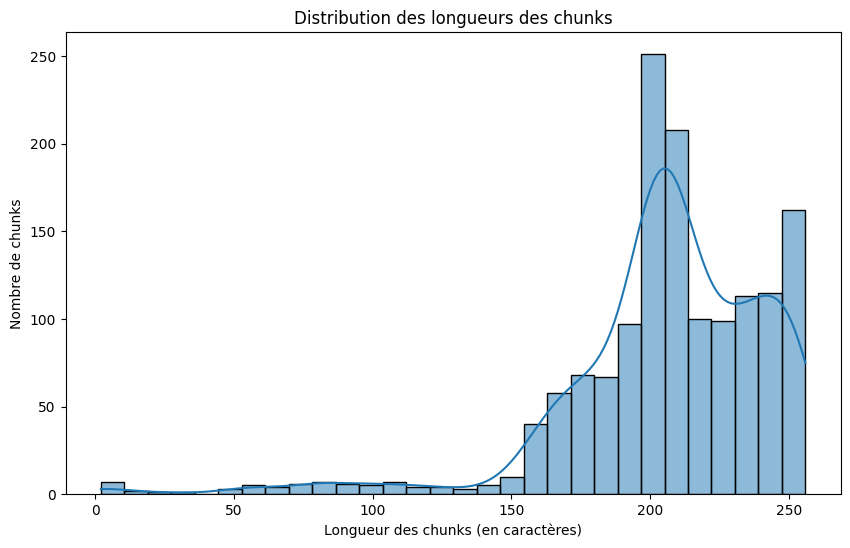

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot([len(text.page_content) for text in texts], bins=30, kde=True)
plt.title("Distribution des longueurs des chunks")
plt.xlabel("Longueur des chunks (en caractères)")
plt.ylabel("Nombre de chunks")
plt.show()

Nous observons des chunks avec très peu de caractères. Inspecter les contenus des documents avec moins de 100 caractères et noter les améliorations possibles.

In [6]:
for doc in texts:
    if len(doc.page_content) < 100:
        print(doc.page_content)
        print("-" * 30)

INTRODUCTION AU MACHINE LEARNING
2022-2026
Théo Lopès-Quintas
------------------------------
vue un peu plus complète du domaine, ainsi qu’un aperçu plus récent des développements en cours.
2
------------------------------
3. À condition que l’algorithme soit performant.
7
------------------------------
Pour essayer de comprendre ce passage, faisons un exercice :
4. Voir l’équation (2.3).
8
------------------------------
données avec lesquelles on mesure notre performance.
10
------------------------------
le résultat, on peut vérifier la cohérence de la formule avec un exercice.
15
------------------------------
Quel est l’intérêt d’ajouter cette pénalité en terme de biais et variance?
19
------------------------------
Figure 2.3– Simulation d’un mini-jeu de basketball
20
------------------------------
L(θ;x, y) =−
h
yln{f θ(x)} + (1−y) ln{1−f θ(x)}
i
Observation positive
Observation négative
24
------------------------------
28
------------------------------
L’idée est de partitionne

Nous avons à présent un ensemble de chunk, il nous reste à construire l'embedding pour stocker toute ces informations. Nous faisons les choix suivants :
* Nous utiliserons l'embedding [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) pour sa taille et son entraînement spécifique à notre tâche
* Nous utiliserons le *vector store* [FAISS](https://python.langchain.com/docs/integrations/vectorstores/faiss/) puisque nous l'avons couvert en cours.
* Nous récupérerons les trois chunks les plus proches, pour commencer

In [7]:
import os

from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

os.environ["USE_TF"] = "false"
os.environ["USE_TORCH"] = "true"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectordb = FAISS.from_documents(texts, embedding_model)
n_doc_to_retrieve = 3
retriever = vectordb.as_retriever(search_kwargs={"k": n_doc_to_retrieve})

Notre base de connaissance est réalisée ! Passons maintenant à l'augmentation du modèle de langage.

## Génération

Pour cette étape, il nous reste à définir le modèle de langage et comment nous allons nous adresser à lui.

**Consigne** : Définir la variable *model* à partir de la classe [OllamaLLM](https://python.langchain.com/api_reference/ollama/llms/langchain_ollama.llms.OllamaLLM.html#ollamallm) et du modèle de votre choix.

In [8]:
from langchain_ollama import OllamaLLM

model = OllamaLLM(model="gemma3:4b", base_url="http://localhost:11434")

**Consigne** : À l'aide de la classe [PromptTemplate](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.prompt.PromptTemplate.html#langchain_core.prompts.prompt.PromptTemplate) et en s'inspirant éventuellement de [cet exemple](https://smith.langchain.com/hub/rlm/rag-prompt), définir un template de prompt qui aura deux *input_variable* : 'context' et 'question'.

In [ ]:
from langchain_classic.prompts import PromptTemplate

prompt_template = PromptTemplate(
    template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:""",
    input_variables=["context", "question"],
)

Pour construire la chaîne de RAG, LangChain utilise le [LangChain Expression Language (LCEL)](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel), voici dans notre cas comment cela se traduit :

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs: list) -> str:
    """Format documents into a single string."""
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt_template
    | model
    | StrOutputParser()
)

Une fois la chaîne définie, nous pouvons lui poser des questions :

In [17]:
query = "Quelle est la citation d'Alan Turing ?"
result = rag_chain.invoke(query)
print("Answer:", result)

Answer: Alan Turing’s famous quote is, “We can only have glimpses of the future, but that is enough to make us realize how much there is to do.” This quote came from his 1950 article, Computing Machinery and Intelligence. It remains relevant today as concerns about security and toxicity increase.


LangChain ne permet pas nativement d'afficher quels chunks ont été utilisé pour produire la réponse, ni le score de similarité. Pour le faire, nous allons utiliser directement FAISS.

**Consigne** : À l'aide de la méthode [`similarity_search_with_score`](https://python.langchain.com/v0.2/docs/integrations/vectorstores/llm_rails/#similarity-search-with-score) de `FAISS`, afficher les trois documents utilisé dans le RAG.

Nous avons finalement bien défini notre premier RAG !

## Amélioration de notre RAG

Mais nous pouvons faire mieux, notamment afficher la source dans la génération pour que l'utilisateur puisse vérifier et mesurer les performances de notre RAG. Une fois que nous aurons réalisé ces deux améliorations, alors nous pourrons modifier plusieurs points techniques spécifique et mesurer l'apport en performance.

### Exploiter les méta-données

Nous avons utilisé la classe `PyPDFLoader` qui charge chaque page dans un document. Nous avons largement utilisé le contenu *page_content* mais l'attribut *metadata* contient deux informations qui nous intéressent : *source* et *page*. 

**Consigne** : Modifier la fonction `format_doc` pour qu'elle prenne en paramètre une liste de document LangChain puis qu'elle affiche la source et la page en plus de seulement le contenu texte.

Maintenant que nous passons des informations sur les métadonnées, il faut s'assurer que le modèle de langage les utilises.

**Consigne** : Modifier le prompt template défini plus tôt pour intégrer cette règle.

Testons à présent avec la même question sur une nouvelle chaîne RAG prenant en compte nos améliorations.

**Consigne** : Définir un nouveau RAG prenant en compte les informations des méta-données, puis poser la même question.

C'est ce que nous souhaitions obtenir ! Mais nous pourrions avoir un format un peu plus structuré et moins libre. Pour cela, nous allons modifier notre système pour qu'il renvoie des JSON !
Commençons par modifier le template de prompt pour lui donner les instructions :

In [ ]:
prompt_template = PromptTemplate(
    template="""
    You are an assistant for question-answering tasks, use the retrieved context to answer the question.  Each piece of context includes metadata (source + page).
    If you don’t know the answer, respond with: {{"answer": "I don't know", "sources": []}}
    Otherwise, return your answer in JSON with this exact structure:
    {{
      "answer": "your answer here",
      "sources": ["source:page", "source:page"]
    }}
    Rules:
    - Answer in the same language as the question.
    - Always include the sources (source:page).
    - Never add extra fields.

    Question: {question}
    Context:\n{context}
    Answer:
    """,
    input_variables=["context", "question"],
)

Puisque nous demandons ici de répondre par exemple : '['ML.pdf:91"], nous allons lui faciliter la tâche en modifiant la fonction `format_docs`.

**Consigne** : Modifier la fonction `format_docs` pour prendre en compte le formattage 'source:page'.

Si nous souhaitons obtenir un JSON, ou un dictionnaire, en sortie du modèle, nous devons modifier la chaîne RAG définie précédemment.

**Consigne** : Remplacer la fonction [`JsonOutputParser`](https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.json.JsonOutputParser.html) à la place de [`StrOutputParser`](https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.string.StrOutputParser.html#langchain_core.output_parsers.string.StrOutputParser) puis tester la nouvelle chaîne RAG avec la même question.

C'est mieux ! Il nous reste à présent à mesurer la performance de notre système.


### Mesurer les performances

Nous avons défini manuellement plusieurs questions dont les réponses sont contenus dans le cours dans le fichier JSON *eval_dataset*.

In [ ]:
import json

with open("eval_dataset.json", encoding="utf-8") as file:
    eval_dataset = json.load(file)

print(eval_dataset[0])

Il sera probablement difficile de mesurer la performance de manière frontale. Ainsi, nous optons pour une méthodologie *LLM as a Judge*.

**Consigne** : Définir une fonction `evaluate_rag` qui prend en paramètre une chaîne RAG et un dataset pour évaluation. La fonction renverra une liste de dictionnaire avec pour clés :
* *question* : la question posée
* *expected_answer* : la réponse attendue
* *predicted_answer* : la réponse obtenue
* *expected_sources* : la ou les sources attendues
* *predicted_sources* : la ou les sources obtenues

**Consigne** : Tester la fonction précédente avec les trois premières questions puis afficher le résultat sous la forme d'un dataframe pandas.

Nous sommes capable d'obtenir un ensemble de réponse de la part d'un modèle avec un RAG, il nous reste à mettre en place le juge.

**Consigne** : Définir un prompt pour décrire le rôle du juge.

**Consigne** : Définir une chaîne pour le juge, de la même manière que le RAG : prompt --> model --> JSONParser

**Consigne** : Modifier la fonction `evaluate_rag` pour qu'elle note directement la performance du modèle et renvoie sous forme d'un dataframe pandas les résultats. On implémentera également des mesures temporelles pour le RAG et le juge, ainsi que des blocs *try...except...* pour ne pas bloquer l'exécution de toutes les requêtes si une renvoie une erreur.
Pour pouvoir suivre l'avancement de l'évaluation, on utilisera la barre de progression tqdm.

**Consigne** : Utiliser cette fonction sur les trois premières question du dataset d'évaluation.

**Consigne** : A partir des résultats précédents, donner des statistiques de performance du modèle.

## Pour aller plus loin

Nous avons plusieurs axes d'améliorations, de manière non exhaustive :
* Une meilleure récupération du texte dans le PDF : par exemple utiliser [Docling](https://python.langchain.com/docs/integrations/document_loaders/docling/) ?
* Une meilleure manière de découper en *chunk* le texte : par exemple utiliser [RecursiveCharacterTextSplitter](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#recursivecharactertextsplitter), ou changer la taille des chunks...
* Un meilleur modèle d'embedding : voir le [leaderboard](https://huggingface.co/spaces/mteb/leaderboard) des embeddings
* Un meilleur retrieval : meilleure méthode pour chercher, par exemple [MMR](https://python.langchain.com/v0.2/docs/how_to/example_selectors_mmr/)
* De meilleurs prompt
* Une meilleure mesure de performance : plus de questions par exemple

Nous encourageons l'étudiant à tester la ou les améliorations qu'ils souhaitent faire et surtout que les apports soit mesurés séparemment. On encourage également d'utiliser ses propres documents et son propre benchmark.
Pour accélérer encore un peu l'évaluation, on propose une version asynchrone de la fonction d'évaluation :

In [ ]:
import asyncio

from tqdm.asyncio import tqdm_asyncio


async def evaluate_rag_async(rag_chain, dataset, judge_chain, max_concurrency=5):
    """Async evaluation of a RAG chain against a dataset using a judge LLM."""
    results = []
    semaphore = asyncio.Semaphore(max_concurrency)

    async def process_example(example):
        async with semaphore:
            rag_start = time.time()
            try:
                prediction = await rag_chain.ainvoke(example["question"])
            except Exception as e:
                prediction = {"answer": "", "sources": []}
                print(f"[RAG ERROR] Question: {example['question']} | {e}")
            rag_end = time.time()

            judge_input = {
                "question": example["question"],
                "expected_answer": example["answer"],
                "predicted_answer": prediction.get("answer", ""),
                "expected_sources": example["sources"],
                "predicted_sources": prediction.get("sources", []),
            }

            judge_start = time.time()
            try:
                judgment = await judge_chain.ainvoke(judge_input)
            except Exception as e:
                judgment = {
                    "answer_correct": False,
                    "sources_correct": False,
                    "explanation": f"Judge error: {e}",
                }
                print(f"[JUDGE ERROR] Question: {example['question']} | {e}")
            judge_end = time.time()

            results.append(
                {
                    **judge_input,
                    **judgment,
                    "rag_time": rag_end - rag_start,
                    "judge_time": judge_end - judge_start,
                    "total_time": judge_end - rag_start,
                },
            )

    tasks = [process_example(example) for example in dataset]
    for f in tqdm_asyncio.as_completed(
        tasks, desc="Evaluating RAG", total=len(dataset),
    ):
        await f

    return pd.DataFrame(results)
